# 0.0 IMPORTS

## 01. Libraries

In [1]:
import datetime
import warnings
import inflection
import pandas as pd
import numpy as np
import scipy.stats  as ss

from IPython.display         import Image
from IPython.core.display    import HTML

import matplotlib.pyplot as plt
import seaborn as sns


# 0.2 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
seed = 42
np.random.seed(seed)

jupyter_settings()

## 0.3 Helper Functions

In [4]:
# Time Decorator
def timer(function):
    def wrapper(get):
        try:
            start = datetime.datetime.now()
            function(get)
            end = datetime.datetime.now()
            delta  = end - start
            print('runtime: ', delta)
            return delta
        except:
            pass
    return wrapper


#@timer
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Mni', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m

## 0.4 Load Data

### 0.4.1 Load Raw Data

In [31]:
%%time
types = {'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,
         'Ruta_SAK':np.uint16, 'Cliente_ID':np.uint32, 'Producto_ID':np.uint16,
         'Demanda_uni_equil':np.uint32}

data_train_raw = pd.read_csv('../00-Data/csv_data/train.csv', usecols=types.keys(), dtype=types)
print(data_train_raw.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Semana             uint8 
 1   Agencia_ID         uint16
 2   Canal_ID           uint8 
 3   Ruta_SAK           uint16
 4   Cliente_ID         uint32
 5   Producto_ID        uint16
 6   Demanda_uni_equil  uint32
dtypes: uint16(3), uint32(2), uint8(2)
memory usage: 1.1 GB
None
Wall time: 41.4 s


In [32]:
data_train_raw.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3
1,3,1110,7,3301,15766,1216,4
2,3,1110,7,3301,15766,1238,4
3,3,1110,7,3301,15766,1240,4
4,3,1110,7,3301,15766,1242,3


In [33]:
%%time
types = {'Producto_ID':np.uint16,
         'NombreProducto':'object'}


data_producto_raw = pd.read_csv('../00-Data/csv_data/producto_tabla.csv', usecols=types.keys(), dtype=types)
print(data_producto_raw.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Producto_ID     2592 non-null   uint16
 1   NombreProducto  2592 non-null   object
dtypes: object(1), uint16(1)
memory usage: 25.4+ KB
None
Wall time: 51.3 ms


In [35]:
data_producto_raw.head()

,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


In [34]:
%%time
types = {'Cliente_ID':np.uint32,
         'NombreCliente':'object'}


data_cliente_raw = pd.read_csv('../00-Data/csv_data/cliente_tabla.csv', usecols=types.keys(), dtype=types)

print(data_cliente_raw.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935362 entries, 0 to 935361
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Cliente_ID     935362 non-null  uint32
 1   NombreCliente  935362 non-null  object
dtypes: object(1), uint32(1)
memory usage: 10.7+ MB
None
Wall time: 471 ms


In [38]:
data_cliente_raw.head()

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


In [36]:
%%time
types = {'Agencia_ID':np.uint16,
         'Town':'object',
         'State':'object'}


data_town_state_raw = pd.read_csv('../00-Data/csv_data/town_state.csv', usecols=types.keys(), dtype=types)
print(data_town_state_raw.info(memory_usage=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Agencia_ID  790 non-null    uint16
 1   Town        790 non-null    object
 2   State       790 non-null    object
dtypes: object(2), uint16(1)
memory usage: 14.0+ KB
None
Wall time: 22 ms


In [37]:
data_town_state_raw.head()

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


### 0.4.2 Merge Dataset

In [40]:
# data_raw = pd.merge(data_train_raw, data_producto_raw, how='left', on='Producto_ID')
# data_raw = pd.merge(data_raw, data_cliente_raw, how='left', on='Cliente_ID')
# data_raw = pd.merge(data_raw, data_town_state_raw, how='left', on='Agencia_ID')
# data_raw = data_raw.drop(['Producto_ID', 'Cliente_ID', 'Agencia_ID'], axis=1)
# data_raw.head()

In [39]:
# print(data_raw.info(memory_usage=True))

### 0.4.3 Deletion of Useless Dataframes

In [30]:
# del data_raw
# del data_train_raw
# del data_producto_raw
# del data_cliente_raw
# del data_town_state_raw

# 1.0 DATA DESCRIPTION

In [41]:
df01 = data_train_raw.copy()

## 1.1 Columns

In [42]:
df01.columns

Index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID',
       'Producto_ID', 'Demanda_uni_equil'],
      dtype='object')

### 1.2.1 Rename Columns

In [43]:
snakecase = lambda col: inflection.underscore(col)

new_columns = list(map(snakecase, df01.columns))

# rename
df01.columns = new_columns

### 1.2.2 New Name Columns

In [44]:
df01.columns

Index(['semana', 'agencia_id', 'canal_id', 'ruta_sak', 'cliente_id',
       'producto_id', 'demanda_uni_equil'],
      dtype='object')

## 1.3 Data Dimensions

In [45]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 74180464
Number of Columns: 7


## 1.4 Data Types

In [46]:
df01.dtypes

semana                uint8
agencia_id           uint16
canal_id              uint8
ruta_sak             uint16
cliente_id           uint32
producto_id          uint16
demanda_uni_equil    uint32
dtype: object

## 1.5 Missing Values

In [47]:
df01.isnull().sum()

semana               0
agencia_id           0
canal_id             0
ruta_sak             0
cliente_id           0
producto_id          0
demanda_uni_equil    0
dtype: int64

### 1.5.2 ~~Fillout NA~~

there is no NA values

## 1.6 Descriptive Statistical

In [14]:
# # Numerical Attributes
# num_attributes = df01.select_dtypes(include=['int64', 'float64'])

In [48]:
## Statatistical Summary (Helper Function)
statistical_summary(df01)

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,semana,3.0,9.000000e+00,6.000000e+00,3.0,5.950021e+00,6.0,3.0,3.0,4.0,8.0,9.0,9.0,2.013175e+00,0.338348,0.032396,-1.267862
1,agencia_id,1110.0,2.575900e+04,2.464900e+04,1911.0,2.536509e+03,1613.0,1121.0,1137.0,1312.0,2036.0,3213.0,4046.0,4.075124e+03,1.606588,4.791190,21.694508
2,canal_id,1.0,1.100000e+01,1.000000e+01,1.0,1.383181e+00,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.463266e+00,1.057899,4.778018,25.022474
3,ruta_sak,1.0,9.991000e+03,9.990000e+03,1201.0,2.114855e+03,1286.0,1018.0,1057.0,1161.0,2802.0,4455.0,5512.0,1.487744e+03,0.703473,1.747052,2.343345
4,cliente_id,26.0,2.015152e+09,2.015152e+09,653378.0,1.802119e+06,1193385.0,64912.0,125603.0,356767.0,2371091.0,4500724.0,4653548.0,2.349577e+06,1.303786,331.508376,283460.947956
5,producto_id,41.0,4.999700e+04,4.995600e+04,1240.0,2.084081e+04,30549.0,1109.0,1150.0,1242.0,37426.0,43206.0,43316.0,1.866392e+04,0.895547,0.036787,-1.832233
6,demanda_uni_equil,0.0,5.000000e+03,5.000000e+03,2.0,7.224564e+00,3.0,1.0,1.0,2.0,6.0,14.0,24.0,2.177119e+01,3.013496,43.037751,4789.810091


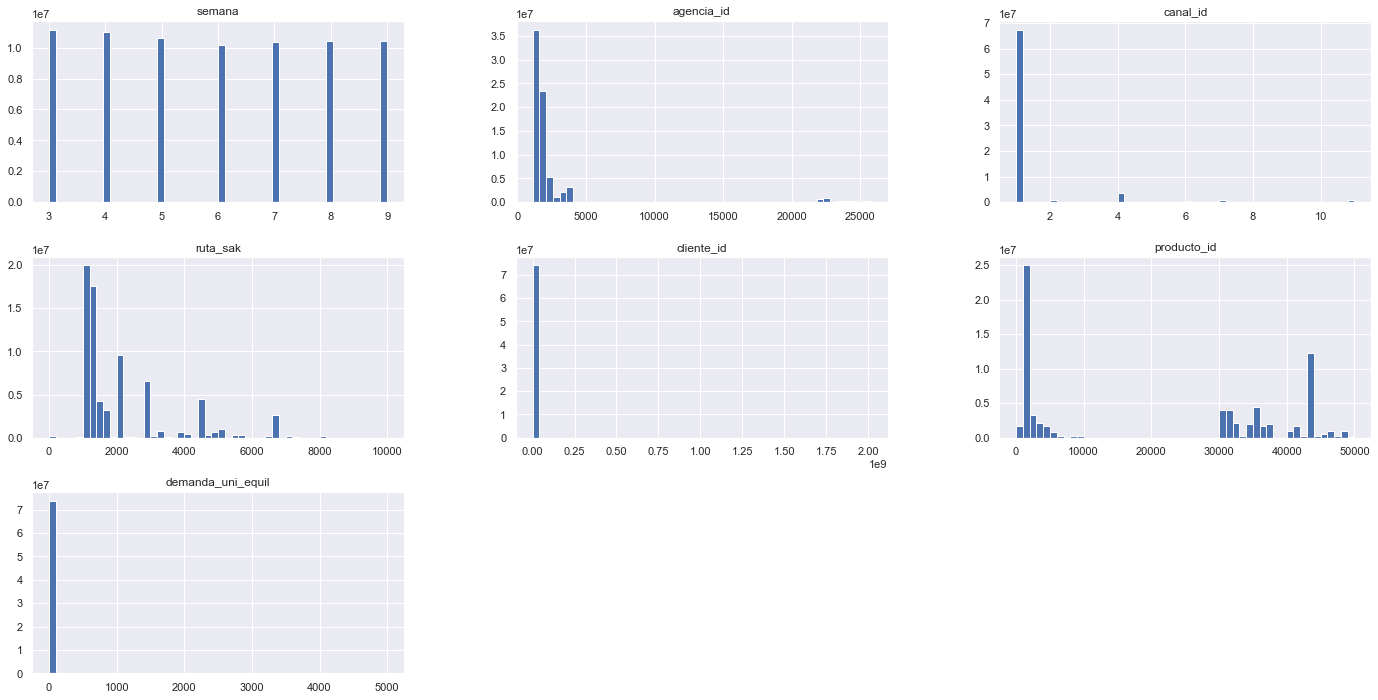

In [49]:
df01.hist(bins=50, figsize=(24,12));

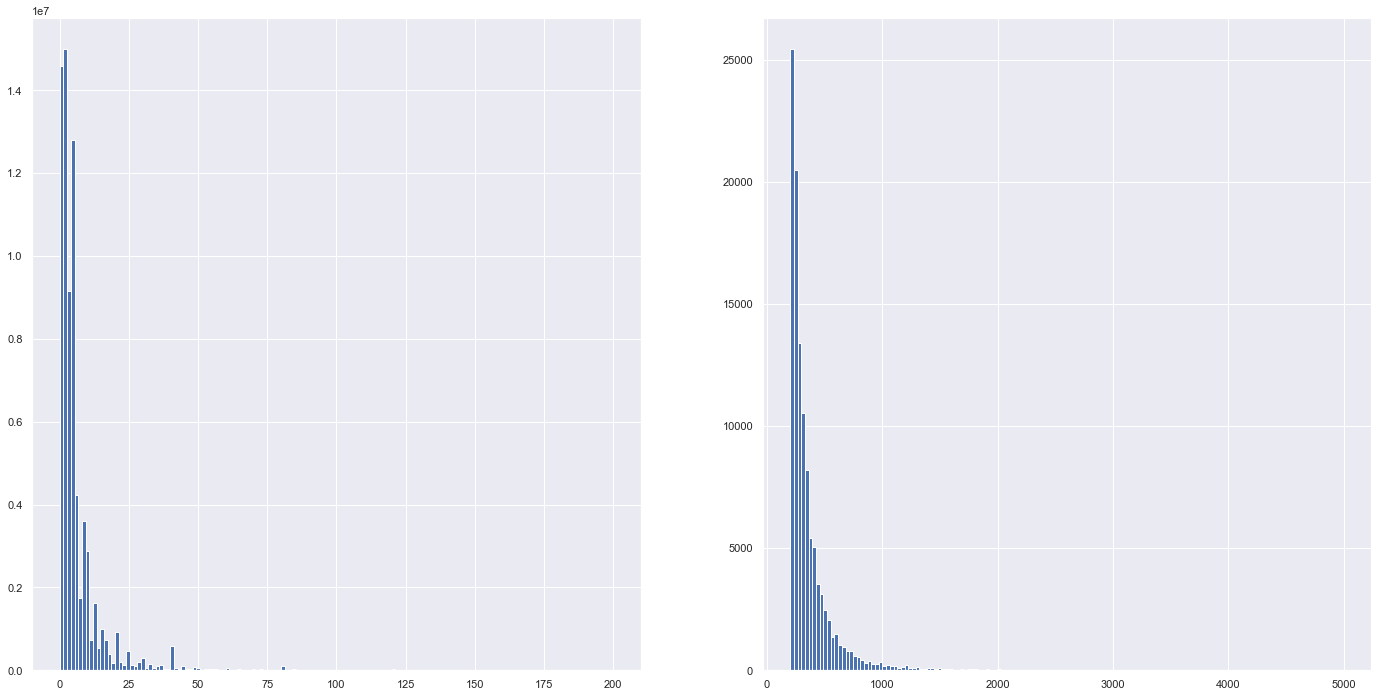

In [64]:
break_point = 200

plt.subplot(1,2,1)
df01['demanda_uni_equil'][df01['demanda_uni_equil'] <= break_point].hist(bins=150, figsize=(24,12));

plt.subplot(1,2,2)
df01['demanda_uni_equil'][df01['demanda_uni_equil'] > break_point].hist(bins=150, figsize=(24,12));

# 2.0 Feature Engineering

## 2.1 Mind Map

### 2.1.1 Formulation of Hypothesis

### 2.1.2 Final Hypothesis List

### 2.2 Feature Engineering